In [10]:
pip install seaborn

     |████████████████████████████████| 283 kB 827 kB/s eta 0:00:01
     |████████████████████████████████| 29.0 MB 2.9 MB/s eta 0:00:01
     |████████████████████████████████| 8.5 MB 19.2 MB/s eta 0:00:01
     |████████████████████████████████| 2.2 MB 27.2 MB/s eta 0:00:01
     |████████████████████████████████| 61 kB 244 kB/s  eta 0:00:01
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
You should consider upgrading via the '/Library/Frameworks/Python.framework/Versions/3.8/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [131]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import re
import datetime
sns.set_style('whitegrid')

In [132]:
df = pd.read_csv('pae_survey.csv')

In [133]:
# SEP utils file
def missing_heat_map(DataFrame):
    
    fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (18, 6))
    sns.heatmap(DataFrame.isnull(), yticklabels=False, ax = ax, cbar=False,\
                cmap='viridis')
    ax.set_title('dataset')
    plt.show()
        
    # Calculate the missing values to get a percentage 

    for i in DataFrame:
        print(i,': %',int((DataFrame[i].isnull().sum()/len(DataFrame[i]))*100),\
            'With {} missing values'.format((DataFrame[i].isnull().sum())))

In [134]:
df.head()

,Timestamp,1) What is your gender?,2) What is your marital status?,3) In which region are you located?,4) Did you get your bachelor degree in Saudi or Abroad?,"5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.",6) Have you ever studied in a mixed-sex university?,"7) After you spend a long day, how do you gain energy?",8) The people who know you best are more likely to describe you as someone who is:,9) Do you think that household chores should be equally divided between men and women? [Choose:],10) Do you prefer working in a single-sex work environment or mixed-sex work environment?,11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender? [Choose:],"12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information? [Choose:]",13) How likely are you willing to work on a project with someone from the opposite gender? [Choose:],"14) If you studied abroad, can you identify any event that influenced your views about gender?",15) Are you with or against mixed-sex universities in Saudi?,16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not.
0,2020/12/02 1:19:18 PM GMT+3,Female,Single,Eastern,Abroad,NaN,"Yes, undergrad",Inner reflection and solitude,Quiet and reflective,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,Against mixed-sex universities,NaN
1,2020/12/02 1:21:06 PM GMT+3,Male,Single,Center,Saudi,Abroad,"Yes, grad",Going out with friends,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Against it, privacy, competitiveness, security"
2,2020/12/02 1:29:40 PM GMT+3,Male,Single,Center,Saudi,NaN,"No, neither",Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"
3,2020/12/02 1:31:00 PM GMT+3,Female,Single,Center,Saudi,NaN,"No, neither",Inner reflection and solitude,Outgoing and talkative,3: Agree,Single-sex work environment,3: Comfortable,4: Highly likely,3: Likely,NaN,Against mixed-sex universities,1- it’s could be a problem in our society’s cu...
4,2020/12/02 1:36:05 PM GMT+3,Female,Single,Eastern,Saudi,NaN,"No, neither",Going out with friends,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,3: Comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,I agree.\n1. Preparing students for mixed-sex ...


In [135]:
df.columns

Index(['Timestamp', '1) What is your gender? ',
       '2) What is your marital status? ',
       '3) In which region are you located? ',
       '4) Did you get your bachelor degree in Saudi or Abroad?',
       '5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.',
       '6) Have you ever studied in a mixed-sex university? ',
       '7) After you spend a long day, how do you gain energy? ',
       '8) The people who know you best are more likely to describe you as someone who is:',
       '9) Do you think that household chores should be equally divided between men and women? [Choose:]',
       '10) Do you prefer working in a single-sex work environment or mixed-sex work environment? ',
       '11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?  [Choose:]',
       '12) If someone from the opposite gender has the information you need at work, how likely will you as

In [136]:
df.rename(columns={'1) What is your gender? ':'gender',
                   '2) What is your marital status? ':'marital_status',
                   '3) In which region are you located? ':'region',
                   '4) Did you get your bachelor degree in Saudi or Abroad?':'bachelor_loc',
                   "5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A.":"masters_loc",
                   '6) Have you ever studied in a mixed-sex university? ':'mixed_sex',
                   '7) After you spend a long day, how do you gain energy? ':'introversion_personal',
                   '8) The people who know you best are more likely to describe you as someone who is:':'introversion_public',
                   '9) Do you think that household chores should be equally divided between men and women? [Choose:]':'household_chores',
                   '10) Do you prefer working in a single-sex work environment or mixed-sex work environment? ':'single_vs_mixed_working_env',
                   '11) In your previous work/internship experience: how comfortable did you feel talking to members of the opposite gender?  [Choose:]':'comfort_with_other_gender',
                   '12) If someone from the opposite gender has the information you need at work, how likely will you ask for the information?  [Choose:]':'comfort_with_help_from_other_gender',
                   '13) How likely are you willing to work on a project with someone from the opposite gender? [Choose:]':'project_with_other_gender',
                   '14) If you studied abroad, can you identify any event that influenced your views about gender?':'events_that_influnced_gender_views',
                   '15) Are you with or against mixed-sex universities in Saudi? ':'with_or_aginst_mixed_sex_universities',
                   '16) What do you think about having mixed-sex universities in Saudi? Please list three reasons why or why not.':'opinion_mixed_sex_universites',
                   'Timestamp':'timestamp'
    
                  },inplace=True)

In [169]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites'],
      dtype='object')

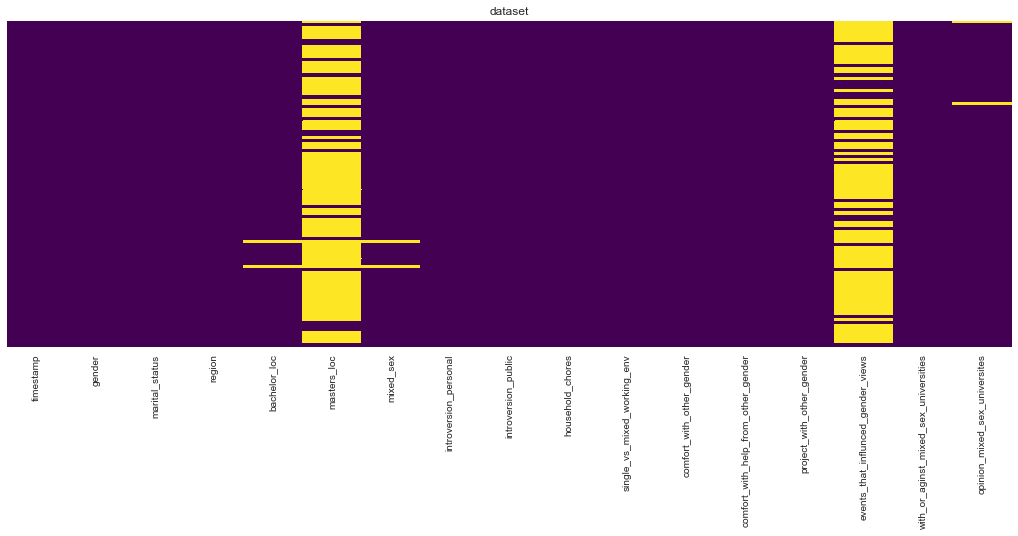

timestamp : % 0 With 0 missing values
gender : % 0 With 0 missing values
marital_status : % 0 With 0 missing values
region : % 0 With 0 missing values
bachelor_loc : % 1 With 2 missing values
masters_loc : % 80 With 84 missing values
mixed_sex : % 1 With 2 missing values
introversion_personal : % 0 With 0 missing values
introversion_public : % 0 With 0 missing values
household_chores : % 0 With 0 missing values
single_vs_mixed_working_env : % 0 With 0 missing values
comfort_with_other_gender : % 0 With 0 missing values
comfort_with_help_from_other_gender : % 0 With 0 missing values
project_with_other_gender : % 0 With 0 missing values
events_that_influnced_gender_views : % 75 With 79 missing values
with_or_aginst_mixed_sex_universities : % 0 With 0 missing values
opinion_mixed_sex_universites : % 1 With 2 missing values


In [137]:
missing_heat_map(df)

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 17 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   timestamp                              104 non-null    object
 1   gender                                 104 non-null    object
 2   marital_status                         104 non-null    object
 3   region                                 104 non-null    object
 4   bachelor_loc                           102 non-null    object
 5   masters_loc                            20 non-null     object
 6   mixed_sex                              102 non-null    object
 7   introversion_personal                  104 non-null    object
 8   introversion_public                    104 non-null    object
 9   household_chores                       104 non-null    object
 10  single_vs_mixed_working_env            104 non-null    object
 11  comfort_with_other_

## Timestamp

In [139]:
#fixed to datetime format
df['timestamp'] = df['timestamp'].apply(lambda x: datetime.datetime.strptime(x.strip('+3'), '%Y/%m/%d %H:%M:%S %p %Z'))

In [140]:
df['timestamp']

0     2020-12-02 01:19:18
1     2020-12-02 01:21:06
2     2020-12-02 01:29:40
3     2020-12-02 01:31:00
4     2020-12-02 01:36:05
              ...        
99    2020-12-14 05:23:38
100   2020-12-14 05:41:25
101   2020-12-14 07:21:38
102   2020-12-15 12:18:42
103   2020-12-15 12:20:47
Name: timestamp, Length: 104, dtype: datetime64[ns]

## gender
**1) What is your gender?**

In [141]:
df['gender'].value_counts()

Male      65
Female    39
Name: gender, dtype: int64

In [201]:
def pie_chart(chart_name,name,column,varibles):
    pie, ax = plt.subplots(figsize=[10,6])
    labels = column.value_counts().keys()
    plt.pie(x=column.value_counts().values, autopct="%.1f%%", explode=[0.05]*int(varibles), labels=labels, pctdistance=0.5)
    plt.title("{}".format(chart_name), fontsize=14);
    pie.savefig("pics/{}.png".format(name))

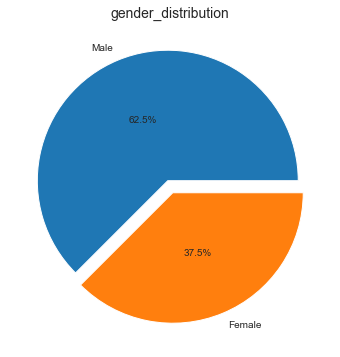

In [202]:
pie_chart('gender_distribution','gender_pie',df['gender'],2)

<AxesSubplot:xlabel='gender', ylabel='Count'>

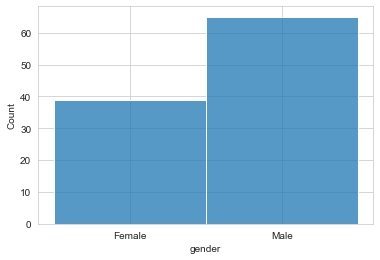

In [144]:
sns.histplot(df['gender'])

## marital_status
**2) What is your marital status?** 

In [145]:
df['marital_status'].value_counts()

Single     98
Married     6
Name: marital_status, dtype: int64

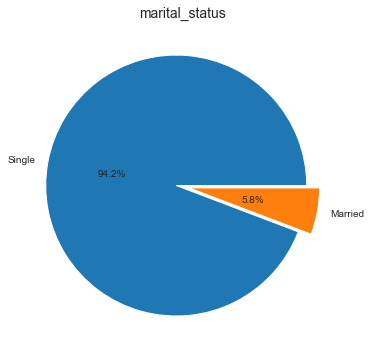

In [146]:
pie_chart('marital_status','marital_status_pie',df['marital_status'],2)

<AxesSubplot:xlabel='marital_status', ylabel='Count'>

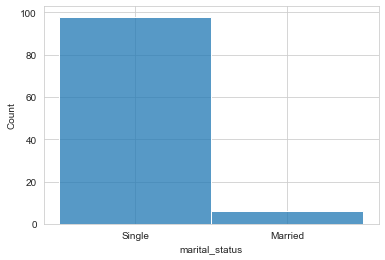

In [147]:
sns.histplot(df['marital_status'])

## region
**3) In which region are you located?**

In [149]:
df['region'].value_counts()

Center     62
Western    26
Eastern    15
Nothern     1
Name: region, dtype: int64

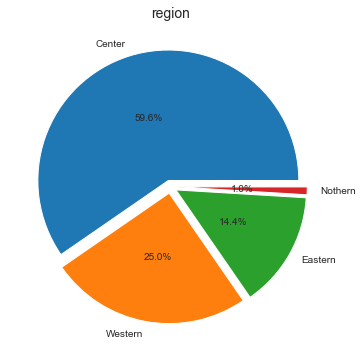

In [150]:
pie_chart('region','region_pie',df['region'],4)

<AxesSubplot:xlabel='region', ylabel='Count'>

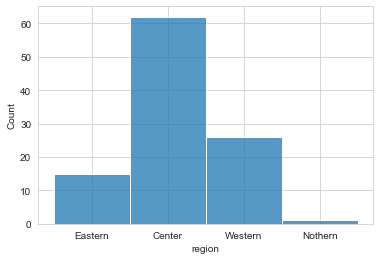

In [151]:
sns.histplot(df['region'])

## bachelor_loc
**4) Did you get your bachelor degree in Saudi or Abroad?**

In [152]:
df['bachelor_loc'].isnull().sum()

2

In [153]:
df[df['bachelor_loc'].isnull()==True]

,timestamp,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,single_vs_mixed_working_env,comfort_with_other_gender,comfort_with_help_from_other_gender,project_with_other_gender,events_that_influnced_gender_views,with_or_aginst_mixed_sex_universities,opinion_mixed_sex_universites
70,2020-12-06 05:02:25,Male,Single,Center,NaN,NaN,NaN,Inner reflection and solitude,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Privacy, Competitiveness, Security"
78,2020-12-12 02:16:21,Male,Single,Center,NaN,NaN,NaN,Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"


In [154]:
df['bachelor_loc'].value_counts()

Saudi     67
Abroad    35
Name: bachelor_loc, dtype: int64

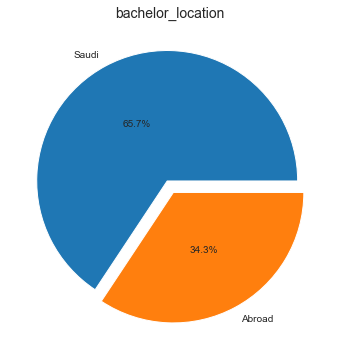

In [155]:
pie_chart('bachelor_location','bachelor_location_pie',df['bachelor_loc'],2)

In [156]:
df['bachelor_loc'].fillna('n/a',inplace=True)

<AxesSubplot:xlabel='bachelor_loc', ylabel='Count'>

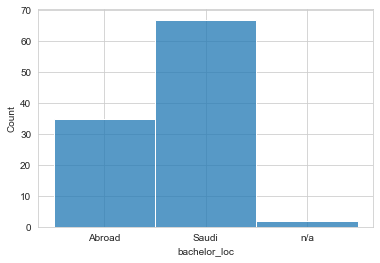

In [157]:
sns.histplot(df['bachelor_loc'])

## Masters_loc
**5) If you have a master's degree, did you study in Saudi or Abroad? If not applicable, please choose N/A**

In [163]:
df['masters_loc'].isnull().sum()

0

In [159]:
df['masters_loc'].value_counts()

Abroad    15
Saudi      5
Name: masters_loc, dtype: int64

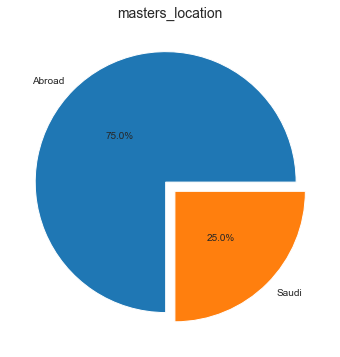

In [160]:
pie_chart('masters_location','masters_location_pie',df['masters_loc'],2)

In [161]:
df['masters_loc'].fillna('n/a',inplace=True)

<AxesSubplot:xlabel='masters_loc', ylabel='Count'>

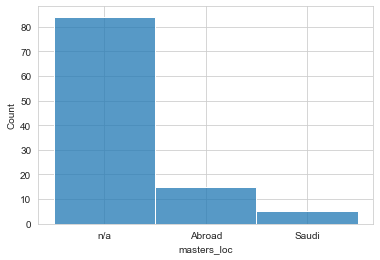

In [162]:
sns.histplot(df['masters_loc'])

## mixed_sex
**6) Have you ever studied in a mixed-sex university?**

In [164]:
df['mixed_sex'].isnull().sum()

2

In [165]:
df[df['mixed_sex'].isnull()==True]

,timestamp,gender,marital_status,region,bachelor_loc,masters_loc,mixed_sex,introversion_personal,introversion_public,household_chores,single_vs_mixed_working_env,comfort_with_other_gender,comfort_with_help_from_other_gender,project_with_other_gender,events_that_influnced_gender_views,with_or_aginst_mixed_sex_universities,opinion_mixed_sex_universites
70,2020-12-06 05:02:25,Male,Single,Center,n/a,n/a,NaN,Inner reflection and solitude,Outgoing and talkative,2: Disagree,Single-sex work environment,3: Comfortable,3: Likely,3: Likely,NaN,Against mixed-sex universities,"Privacy, Competitiveness, Security"
78,2020-12-12 02:16:21,Male,Single,Center,n/a,n/a,NaN,Inner reflection and solitude,Outgoing and talkative,4: Strongly agree,Mixed-sex work environment,4: Very comfortable,4: Highly likely,4: Highly likely,NaN,With mixed-sex universities,"Open mind, ice breaks and better environment"


In [166]:
df['mixed_sex'].value_counts()

Yes, undergrad    52
No, neither       31
Yes, grad         10
Yes, both          9
Name: mixed_sex, dtype: int64

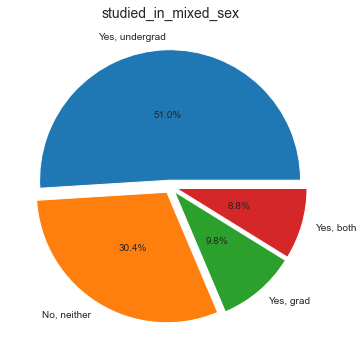

In [167]:
pie_chart('studied_in_mixed_sex','mixedsex_experince_pie',df['mixed_sex'],4)

In [168]:
df['mixed_sex'].fillna('n/a',inplace=True)

In [170]:
df.columns

Index(['timestamp', 'gender', 'marital_status', 'region', 'bachelor_loc',
       'masters_loc', 'mixed_sex', 'introversion_personal',
       'introversion_public', 'household_chores',
       'single_vs_mixed_working_env', 'comfort_with_other_gender',
       'comfort_with_help_from_other_gender', 'project_with_other_gender',
       'events_that_influnced_gender_views',
       'with_or_aginst_mixed_sex_universities',
       'opinion_mixed_sex_universites'],
      dtype='object')

## introversion_personal
**7) After you spend a long day, how do you gain energy?**

In [172]:
df['introversion_personal'].value_counts()

Inner reflection and solitude    66
Going out with friends           38
Name: introversion_personal, dtype: int64

<AxesSubplot:xlabel='introversion_personal', ylabel='Count'>

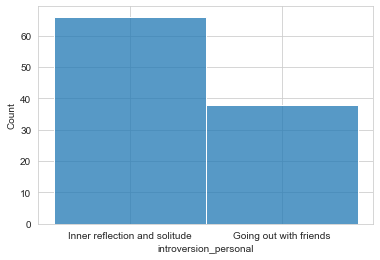

In [173]:
sns.histplot(df['introversion_personal'])

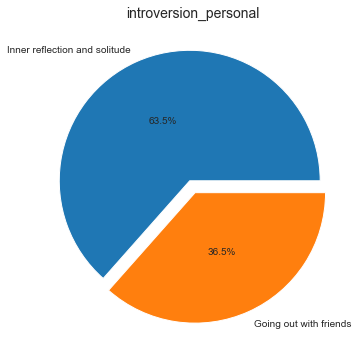

In [174]:
pie_chart('introversion_personal','introversion_personal_pie',df['introversion_personal'],2)

## introversion_public
**8) The people who know you best are more likely to describe you as someone who is:**

In [177]:
df['introversion_public'].value_counts()

Outgoing and talkative    62
Quiet and reflective      42
Name: introversion_public, dtype: int64

<AxesSubplot:xlabel='introversion_public', ylabel='Count'>

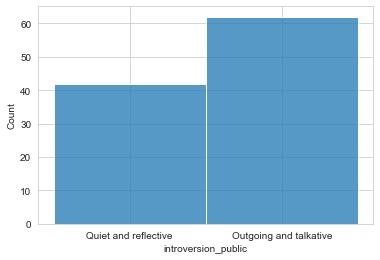

In [178]:
sns.histplot(df['introversion_public'])

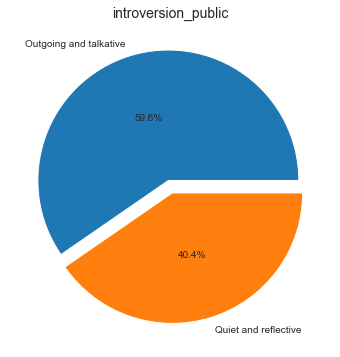

In [179]:
pie_chart('introversion_public','introversion_public_pie',df['introversion_public'],2)

## <font color='red'>introversion(new_feature)</font>

In [193]:
introversion = []
for i in range(0,len(df)):
    if df['introversion_personal'][i]=='Going out with friends' and df['introversion_public'][i]=='Outgoing and talkative':
        introversion.append('extrovert')
    elif df['introversion_personal'][i]=='Inner reflection and solitude' and df['introversion_public'][i]=='Quiet and reflective':
        introversion.append('introvert')
    else:
        introversion.append('introvert/extrovert')
        
    
df['introversion'] = introversion

In [196]:
df[['introversion_personal','introversion_public','introversion']].head(5)

,introversion_personal,introversion_public,introversion
0,Inner reflection and solitude,Quiet and reflective,introvert
1,Going out with friends,Outgoing and talkative,extrovert
2,Inner reflection and solitude,Outgoing and talkative,introvert/extrovert
3,Inner reflection and solitude,Outgoing and talkative,introvert/extrovert
4,Going out with friends,Outgoing and talkative,extrovert


In [198]:
df['introversion'].value_counts()

introvert/extrovert    52
introvert              28
extrovert              24
Name: introversion, dtype: int64

<AxesSubplot:xlabel='introversion', ylabel='Count'>

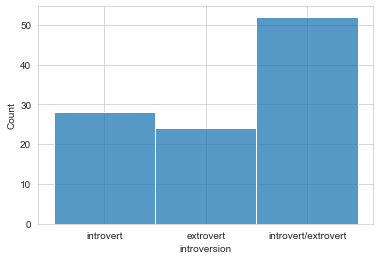

In [199]:
sns.histplot(df['introversion'])

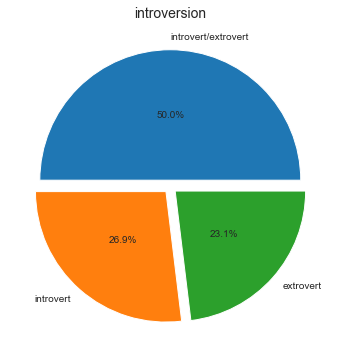

In [200]:
pie_chart('introversion','introversion_pie',df['introversion'],3)